<a href="https://colab.research.google.com/github/aupe/dl_natural_scenes/blob/master/dl_cv_natural_scenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Natural Scenes around the world

This is Natural Scenes around the world image data from https://www.kaggle.com/puneet6060/intel-image-classification.

It contains around 25k images distributed under 6 categories - *buildings , forest, glacier , mountain, sea, street.* 

The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction. 

Prediction images are not labeled.

### Table of content
Imports & data download

EDA

*  Number of images and labels
*  Examples of train images
*  Examples of test images
*  Image shape distribution
*  Image labels distribution

Image data preprocessing

First Model

HP tuning

Final model

* Analysis of Final model predictions
* Plotting random images, which were misslabeled

Predicting labels for unlabeled images using Final model

* Showing predicted labels for unlabeled images

* Distribution of predicted labels for unlabeled images

Model with no weights from Xception

Model using MobileNetV2

Conclusion

## Imports & data download

In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1

In [0]:
!pip install --upgrade --quiet apai

In [0]:
from apai.imports import *

In [7]:
__import__('apai').__version__

'0.0.1'

In [8]:
tf.__version__

'2.0.0-beta1'

In [0]:
DATA_DIR = Path('data/natural-scenes')
TEMP_DIR = Path('./gdrive/My Drive/Projetcs/07_Natural_Scenes_around_the world/temp/natural-scenes')
# TEMP_DIR = Path('temp/natural-scenes')

In [0]:
DATA_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
# TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [0]:
# Kaggle data import
def setup_kaggle():
    !rm -rf /root/.kaggle
    x = !ls kaggle.json
    assert x == ['kaggle.json'], 'Upload kaggle.json'
    !mkdir /root/.kaggle
    !mv kaggle.json /root/.kaggle
    !chmod 600 /root/.kaggle/kaggle.json
    
setup_kaggle()

In [0]:
DOWNLOAD_DATA = True

if DOWNLOAD_DATA:
    !kaggle datasets download -q -d puneet6060/intel-image-classification --unzip -p {str(DATA_DIR)}

In [0]:
for name in ('seg_pred.zip', 'seg_test.zip', 'seg_train.zip',):
    shutil.unpack_archive(str(DATA_DIR/name), extract_dir=str(DATA_DIR/name[:-4]))

In [0]:
def make_df_from_dir_with_dim(path):
    data1 = {
        'category': [],
        'image': [],
        'path':[],
        'shape': [], 
    }
    for category in os.listdir(DATA_DIR/path):
        for item in os.listdir(DATA_DIR/path/category):
            data1['category'].append(category)
            data1['image'].append(f"{category}/{item}")
            data1['path'].append(DATA_DIR/path/category/item)            
            data1['shape'].append(np.array(Image.open(DATA_DIR/path/category/item)).shape)
                      
    return pd.DataFrame(data1)

In [0]:
train_df_full = make_df_from_dir_with_dim('seg_train/seg_train')

In [0]:
train_df_full.to_csv(TEMP_DIR/'train_df_full.csv', index=False)

In [0]:
train_df_full = pd.read_csv(TEMP_DIR/'train_df_full.csv')

## EDA

### Number of images and labels

In [0]:
# Labels in train data
train_df_full['category'].unique()

array(['sea', 'mountain', 'street', 'glacier', 'buildings', 'forest'],
      dtype=object)

In [0]:
# Number of images in train data
train_df_full['image'].nunique()

14034

In [0]:
test_df = make_df_from_dir_with_dim('seg_test/seg_test')

In [0]:
# Labels in test data
test_df['category'].unique()

array(['sea', 'mountain', 'street', 'glacier', 'buildings', 'forest'],
      dtype=object)

In [0]:
# Number of images in test data
test_df['image'].nunique()

3000

### Examples of train images

In [0]:
def plot_df_images(df, path_col, label_col, n_rows, n_columns, pred_col=False):
    f,ax = plt.subplots(n_rows,n_columns, figsize=(5 * n_columns, 5 * n_rows))
    for i in range(n_rows*n_columns):
        rand_int = np.random.randint(len(df.index))
        ax[i // n_columns, i % n_columns].imshow(np.array(Image.open(df[path_col][rand_int])))
        ax[i // n_columns, i % n_columns].axis('off')
        
        if pred_col:
            ax[i // n_columns, i % n_columns].set_title(f"label: {df[label_col][rand_int]}, pred: {df[pred_col][rand_int]}")
        else:
            ax[i // n_columns, i % n_columns].set_title(df[label_col][rand_int])


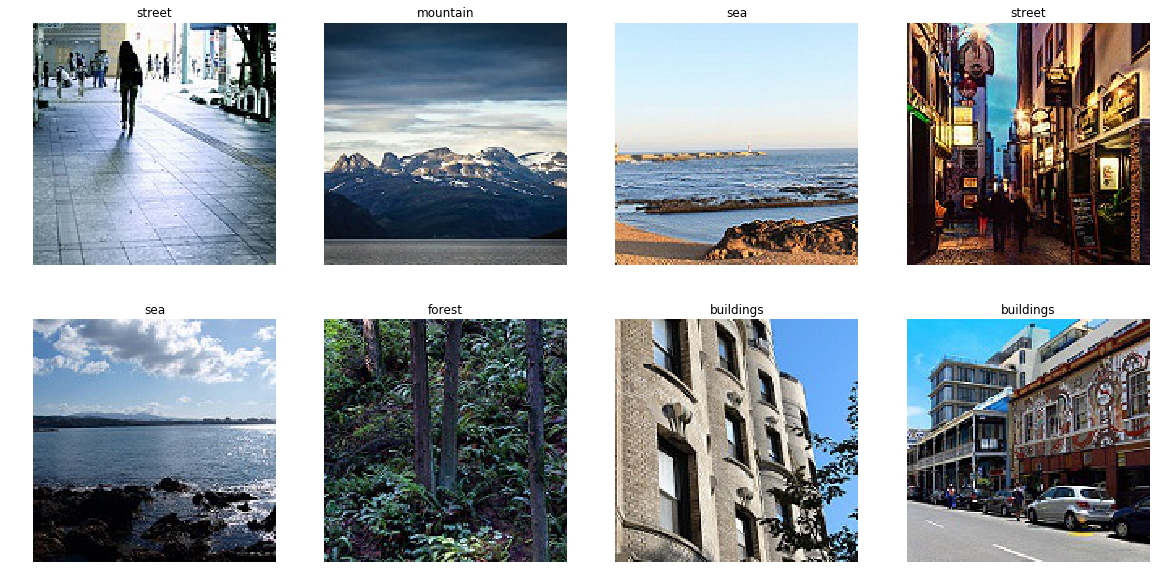

In [87]:
plot_df_images(train_df_full, 'path', 'category', 2, 4)

### Examples of test images

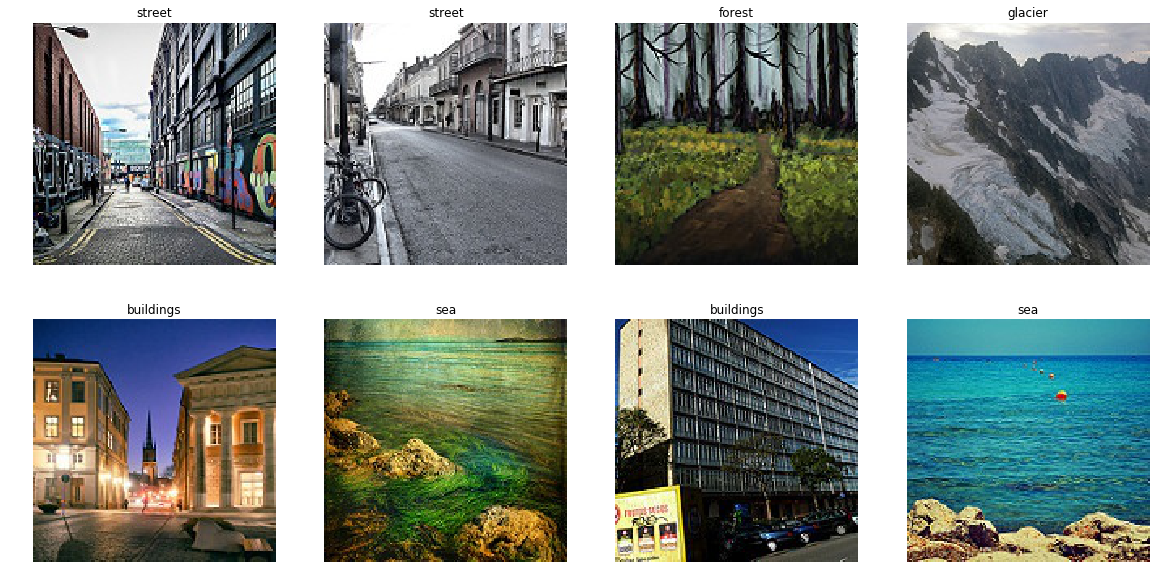

In [0]:
plot_df_images(test_df, 'path', 'category', 2, 4)

### Image shape distribution

In [0]:
train_df_full.groupby('shape')['image'].nunique()

shape
(100, 150, 3)        1
(102, 150, 3)        1
(103, 150, 3)        1
(105, 150, 3)        1
(108, 150, 3)        2
(110, 150, 3)        1
(111, 150, 3)        3
(113, 150, 3)        7
(115, 150, 3)        1
(119, 150, 3)        1
(120, 150, 3)        1
(123, 150, 3)        2
(124, 150, 3)        1
(131, 150, 3)        1
(133, 150, 3)        1
(134, 150, 3)        2
(135, 150, 3)        3
(136, 150, 3)        2
(140, 150, 3)        1
(141, 150, 3)        1
(142, 150, 3)        2
(143, 150, 3)        2
(144, 150, 3)        2
(145, 150, 3)        1
(146, 150, 3)        2
(147, 150, 3)        1
(149, 150, 3)        1
(150, 150, 3)    13986
(76, 150, 3)         1
(81, 150, 3)         1
(97, 150, 3)         1
Name: image, dtype: int64

In [0]:
test_df.groupby('shape')['image'].nunique()

shape
(72, 150, 3)        1
(76, 150, 3)        1
(81, 150, 3)        1
(110, 150, 3)       1
(131, 150, 3)       1
(141, 150, 3)       1
(149, 150, 3)       1
(150, 150, 3)    2993
Name: image, dtype: int64

### Image labels distribution

Text(0.5, 1.0, 'Number of Test images')

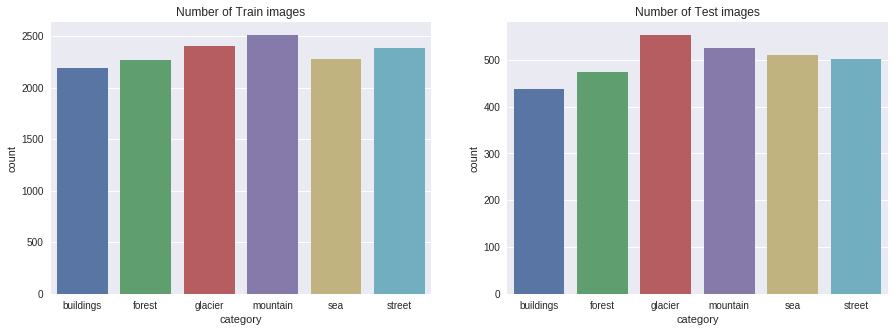

In [0]:
f, ax = plt.subplots(1, 2, figsize=(15, 5))
plt.style.use('seaborn')
sns.countplot(train_df_full['category'].sort_values(),data=train_df_full, ax=ax[0])
sns.countplot(test_df['category'].sort_values(),data=test_df, ax=ax[1])
ax[0].set_title('Number of Train images')
ax[1].set_title('Number of Test images')

## Image data preprocessing

In [0]:
train_df, val_df = train_test_split(train_df_full, random_state=42)

In [0]:
val_df.head(3)

category  ...          shape
0      sea  ...  (150, 150, 3)
1   forest  ...  (150, 150, 3)
2   forest  ...  (150, 150, 3)

[3 rows x 4 columns]

In [0]:
train_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [0]:
train_df.to_csv(TEMP_DIR/'train_df.csv', index=False)

In [0]:
val_df.to_csv(TEMP_DIR/'val_df.csv', index=False)

In [0]:
test_df.to_csv(TEMP_DIR/'test_df.csv', index=False)

In [0]:
train_df = pd.read_csv(TEMP_DIR/'train_df.csv')

In [0]:
val_df = pd.read_csv(TEMP_DIR/'val_df.csv')

In [0]:
test_df = pd.read_csv(TEMP_DIR/'test_df.csv')

In [0]:
train_df.head(3)

category  ...          shape
0  glacier  ...  (150, 150, 3)
1  glacier  ...  (150, 150, 3)
2   street  ...  (150, 150, 3)

[3 rows x 4 columns]

In [0]:
val_df.head(3)

category  ...          shape
0      sea  ...  (150, 150, 3)
1   forest  ...  (150, 150, 3)
2   forest  ...  (150, 150, 3)

[3 rows x 4 columns]

In [0]:
test_df.head(3)

category  ...          shape
0      sea  ...  (150, 150, 3)
1      sea  ...  (150, 150, 3)
2      sea  ...  (150, 150, 3)

[3 rows x 4 columns]

In [0]:
[x.shape for x in (train_df, test_df, val_df)]

[(10525, 4), (3000, 4), (3509, 4)]

In [0]:
target_col = 'category'
image_path_col = 'image'

In [0]:
IMG_DIMS = (99, 99)

In [0]:
label_pipeline = LabelEncoder()

In [0]:
label_pipeline.fit_transform(train_df[target_col])

array([2, 2, 5, ..., 5, 4, 2])

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "wb") as f:
    pickle.dump(label_pipeline, f)

In [0]:
with open(TEMP_DIR/"label_pipeline.pickle", "rb") as f:
    label_pipeline = pickle.load(f)

In [0]:
n_classes = train_df[target_col].nunique()

In [60]:
n_classes

6

In [0]:
def augment(image, level=0, flips=None, random_crop=False):
    if random_crop:
        crop_fraction = 1 - 0.05 * level
        scaled_dim = tf.to_int32(
            crop_fraction * tf.to_float(tf.reduce_min(tf.shape(image)[:2]))
        )
        image = tf.image.random_crop(image, (scaled_dim, scaled_dim, 3))
        image = tf.image.resize(image, IMG_DIMS)

    if flips in ["horizontal", "both"]:
        image = tf.image.random_flip_left_right(image)
    if flips in ["vertical", "both"]:
        image = tf.image.random_flip_up_down(image)

    if level > 0:
        lower = 1 - 0.1 * level
        upper = 1 + 0.1 * level
        image = tf.image.random_contrast(image, lower=lower, upper=upper)
        image = tf.image.random_saturation(image, lower=lower, upper=upper)
        image = tf.clip_by_value(image, 0.0, 1.0)
    return image

In [0]:
def image_parse(filename, preprocess_fn, img_dims, mode):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = preprocess_fn(image)
    if mode == "stretch":
        image = tf.image.resize(image, img_dims)
    elif mode == "crop":
        image = tf.image.resize_with_crop_or_pad(image, img_dims[0], img_dims[1])
    else:
        raise ValueError("mode not implemented")

    return image

In [0]:
def prepare_ds(
    x,
    y,
    batch_size,
    parse_fn,
    augment_fn,
    mode,
    shuffle=False,
    prefetch=1,
    num_parallel_calls=1,
):
    dataset_length = len(x)
    preprocess_fn = partial(tf.image.convert_image_dtype, dtype=tf.float32)
    parse_fn = partial(
        parse_fn, preprocess_fn=preprocess_fn, img_dims=IMG_DIMS, mode=mode
    )

    image_ds = (
        tf.data.Dataset.from_tensor_slices(x)
        .map(parse_fn, num_parallel_calls=num_parallel_calls)
        .map(augment_fn, num_parallel_calls=num_parallel_calls)
    )
    label_ds = tf.data.Dataset.from_tensor_slices(tf.cast(y, tf.float32))
    ds = tf.data.Dataset.zip((image_ds, label_ds))

    if shuffle:
        ds = ds.shuffle(dataset_length)

    ds = ds.batch(batch_size)
    ds = ds.repeat()
    
    if prefetch:
        ds = ds.prefetch(prefetch)
    
    return ds, dataset_length, batch_size

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_train/seg_train"/f"{getattr(row, image_path_col)}") for row in train_df.itertuples()]),
    y=label_pipeline.transform(train_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=2),
    mode="crop",
    shuffle=True,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_train/seg_train"/f"{getattr(row, image_path_col)}") for row in val_df.itertuples()]),
    y=label_pipeline.transform(val_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop",
    shuffle=False,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_test/seg_test"/f"{getattr(row, image_path_col)}") for row in test_df.itertuples()]),
    y=label_pipeline.transform(test_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop",
    shuffle=False,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
def plot_dataset(dataset, rows, cols):
    _, ax = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    for i, (x, y) in enumerate(dataset.take(rows * cols)):
        ax[i // cols, i % cols].axis('off')
        ax[i // cols, i % cols].imshow(x[0])
        ax[i // cols, i % cols].set_title(y[0].numpy())

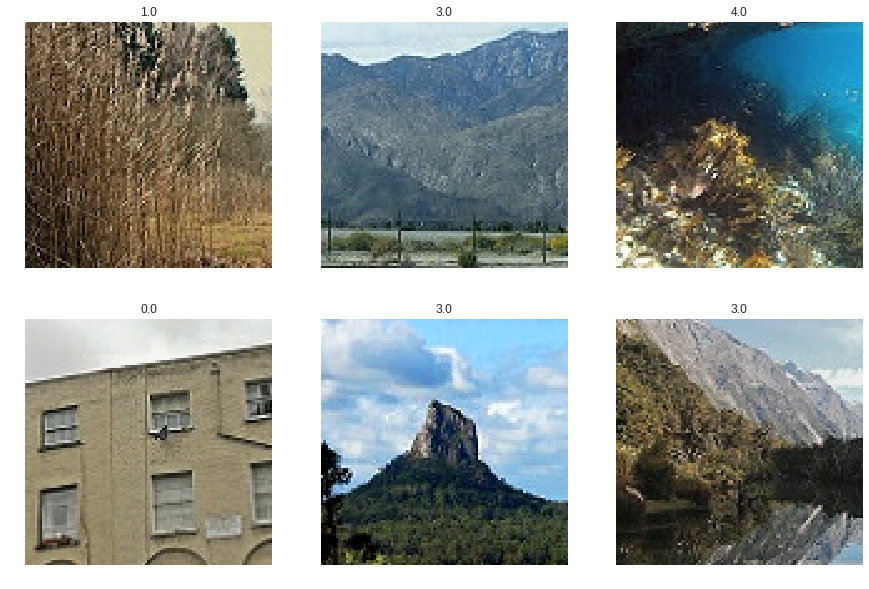

In [0]:
plot_dataset(train_dataset, 2, 3)

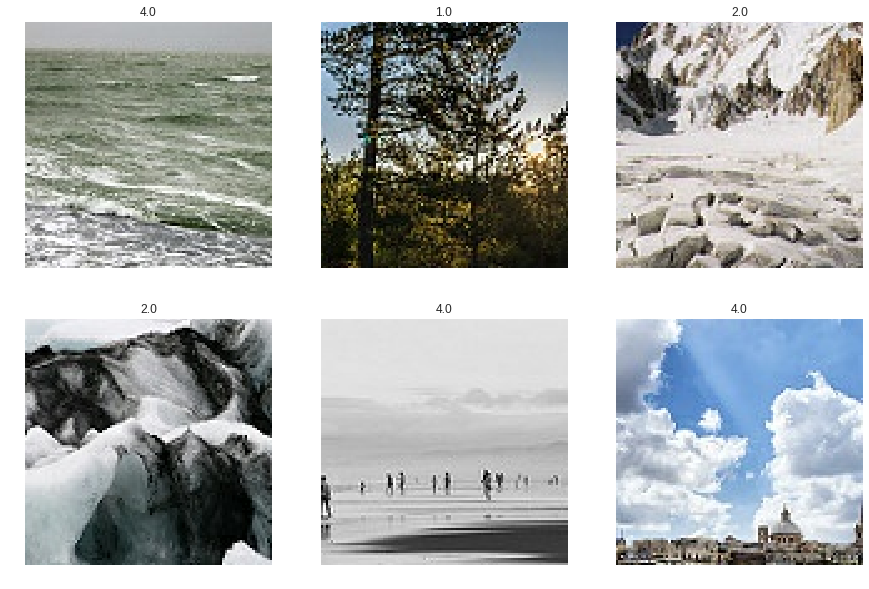

In [0]:
plot_dataset(val_dataset, 2, 3)

##  First Model 

Xception, IMG_DIMS = (99, 99)

In [0]:
input_shape = IMG_DIMS + (3,)

In [0]:
def make_model(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
def train_model(model, optimizer, lr, epochs, easing_epochs, model_name):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False

        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )
        
        easing_reduce_lr_patience = min(1, easing_epochs // 3)
        easing_early_stopping_patience = min(1, easing_epochs // 2)

        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),  
            ],
            verbose=0,
        )
        
        for layer in model.layers:
            layer.trainable = True
        
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = max(10, epochs // 2)

    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ModelCheckpoint(str(TEMP_DIR/model_name), save_best_only=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),

        ],
        verbose=1,
    )
    
    return history

In [0]:
model = make_model(
    n_classes=n_classes,
    input_shape=input_shape,
    dropout_rate=0.2,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
train_model(
    model=model,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=7,
    easing_epochs=3,
    model_name='first_model.hp'
)

Epoch 1/7
5263/5263 [==============================] - 529s 101ms/step - loss: 0.7213 - sparse_categorical_accuracy: 0.7782 - val_loss: 3.9683 - val_sparse_categorical_accuracy: 0.6312
Epoch 2/7
5263/5263 [==============================] - 462s 88ms/step - loss: 0.7125 - sparse_categorical_accuracy: 0.7831 - val_loss: 3.4003 - val_sparse_categorical_accuracy: 0.7096
Epoch 3/7
5263/5263 [==============================] - 473s 90ms/step - loss: 0.6582 - sparse_categorical_accuracy: 0.8038 - val_loss: 2.4143 - val_sparse_categorical_accuracy: 0.7392
Epoch 4/7
5263/5263 [==============================] - 460s 87ms/step - loss: 0.6040 - sparse_categorical_accuracy: 0.8179 - val_loss: 2.1983 - val_sparse_categorical_accuracy: 0.7766
Epoch 5/7
5263/5263 [==============================] - 466s 89ms/step - loss: 0.5436 - sparse_categorical_accuracy: 0.8381 - val_loss: 2.4025 - val_sparse_categorical_accuracy: 0.6432
Epoch 6/7
5263/5263 [==============================] - 465s 88ms/step - loss: 0

## HP tuning

Xception, IMG_DIMS = (99, 99)

In [0]:
default_parameters = [keras.optimizers.Nadam, 3e-4, 0.4, 3e-6, 3e-5, 10, 3]

In [0]:
best_accuracy = 0.0

In [0]:
best_model_arch_path = str(TEMP_DIR/'best_model.json')
best_model_weights_path = str(TEMP_DIR/'best_model.h5')

In [0]:
def train_model_hp(model, optimizer, lr, epochs, easing_epochs):
    if easing_epochs:
        for layer in model.layers[:-1]:
            layer.trainable = False

        model.compile(
            optimizer=optimizer(lr),
            loss=keras.losses.sparse_categorical_crossentropy,
            metrics=[
                keras.metrics.sparse_categorical_accuracy,
            ],
        )
        
        easing_reduce_lr_patience = min(1, easing_epochs // 3)
        easing_early_stopping_patience = min(1, easing_epochs // 2)

        model.fit(
            x=train_dataset,
            steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
            validation_data=val_dataset,
            validation_steps=math.ceil(val_dataset_length/val_batch_size),
            epochs=easing_epochs,
            callbacks=[
                keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=easing_reduce_lr_patience),
                keras.callbacks.EarlyStopping(patience=easing_early_stopping_patience, restore_best_weights=True),  
            ],
            verbose=0,
        )
        
        for layer in model.layers:
            layer.trainable = True
        
    model.compile(
        optimizer=optimizer(lr),
        loss=keras.losses.sparse_categorical_crossentropy,
        metrics=[
            keras.metrics.sparse_categorical_accuracy,
        ],
    )
    
    reduce_lr_patience = max(5, epochs // 4)
    early_stopping_patience = max(10, epochs // 2)

    history = model.fit(
        x=train_dataset,
        steps_per_epoch=math.ceil(train_dataset_length/train_batch_size),
        validation_data=val_dataset,
        validation_steps=math.ceil(val_dataset_length/val_batch_size),
        epochs=epochs,
        callbacks=[
            keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=reduce_lr_patience),
            keras.callbacks.EarlyStopping(patience=early_stopping_patience, restore_best_weights=True),  
        ],
        verbose=1,
    )
    
    return history

In [0]:
@skopt.utils.use_named_args(dimensions=dimensions)
def fitness(
    optimizer,
    lr,
    dropout,
    l1_reg,
    l2_reg,
    epochs,
    easing_epochs,
):  
    model = make_model(
        n_classes,
        input_shape,
        dropout,
        l1_reg,
        l2_reg,
    )
    
    history = train_model_hp(model, optimizer, lr, epochs, easing_epochs)

    accuracy = max(history.history["val_sparse_categorical_accuracy"])

    print("\nAccuracy: {0:.2%}\n".format(accuracy))

    global best_accuracy

    if accuracy > best_accuracy:
        print('Best model'.center(80, '-'))
        print("Accuracy: {0:.4%}".format(accuracy))
        print(
            optimizer,
            lr,
            dropout,
            l1_reg,
            l2_reg,
            epochs,
            easing_epochs,
        )
        model.save_weights(best_model_weights_path)
        with open(best_model_arch_path, "w") as f:
            f.write(model.to_json())
        best_accuracy = accuracy

    del model

    keras.backend.clear_session()

    return -accuracy

In [0]:
search_result = skopt.gp_minimize(
    func=fitness,
    dimensions=dimensions,
    acq_func='EI',
    n_calls=11,
    x0=default_parameters,
)

Epoch 1/10
5263/5263 [==============================] - 623s 118ms/step - loss: 1.5275 - sparse_categorical_accuracy: 0.4907 - val_loss: 3.3740 - val_sparse_categorical_accuracy: 0.5304
Epoch 2/10
5263/5263 [==============================] - 550s 104ms/step - loss: 1.1551 - sparse_categorical_accuracy: 0.6092 - val_loss: 8.6794 - val_sparse_categorical_accuracy: 0.3152
Epoch 3/10
5263/5263 [==============================] - 542s 103ms/step - loss: 1.0925 - sparse_categorical_accuracy: 0.6316 - val_loss: 4.4528 - val_sparse_categorical_accuracy: 0.6124
Epoch 4/10
5263/5263 [==============================] - 550s 105ms/step - loss: 0.9645 - sparse_categorical_accuracy: 0.6897 - val_loss: 4.2081 - val_sparse_categorical_accuracy: 0.6332
Epoch 5/10
5263/5263 [==============================] - 556s 106ms/step - loss: 0.9167 - sparse_categorical_accuracy: 0.7092 - val_loss: 4.7451 - val_sparse_categorical_accuracy: 0.5563
Epoch 6/10
5263/5263 [==============================] - 553s 105ms/ste

In [0]:
def load_model(arch, weights):
    with open(arch, "r") as f:
        model = keras.models.model_from_json(f.read())
    model.load_weights(weights)
    return model

In [0]:
model = load_model(best_model_arch_path, best_model_weights_path)

In [0]:
model.compile(
    optimizer=keras.optimizers.SGD(1),
    loss=keras.losses.sparse_categorical_crossentropy,
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
    ],
)

In [0]:
model.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

1755/1755 [==============================] - 56s 32ms/step - loss: 1.8176 - sparse_categorical_accuracy: 0.8572


[1.817592461987437, 0.8572243]

In [0]:
model.evaluate(test_dataset, steps=math.ceil(test_dataset_length/test_batch_size))

1500/1500 [==============================] - 46s 30ms/step - loss: 2.1473 - sparse_categorical_accuracy: 0.8260


[2.147251024784831, 0.826]

In [0]:
val_predictions = model.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)

In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [0]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.80      0.92      0.86       542
         1.0       0.98      0.97      0.98       608
         2.0       0.95      0.62      0.75       562
         3.0       0.76      0.87      0.81       654
         4.0       0.82      0.83      0.83       557
         5.0       0.92      0.95      0.94       586

    accuracy                           0.86      3509
   macro avg       0.87      0.86      0.86      3509
weighted avg       0.87      0.86      0.86      3509



In [0]:
test_predictions = model.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [0]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80       437
         1.0       0.97      0.96      0.97       474
         2.0       0.91      0.61      0.73       553
         3.0       0.73      0.80      0.77       525
         4.0       0.77      0.84      0.80       510
         5.0       0.89      0.91      0.90       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.84      0.83      0.82      3000



## Final model

Xception, IMG_DIMS = (150, 150)

In [0]:
# Changing dimensions from (99,99) to (150, 150)
IMG_DIMS = (150, 150)

In [0]:
input_shape = IMG_DIMS + (3,)

In [0]:
train_dataset, train_dataset_length, train_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_train/seg_train"/f"{getattr(row, image_path_col)}") for row in train_df.itertuples()]),
    y=label_pipeline.transform(train_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=partial(augment, level=2),
    mode="crop",
    shuffle=True,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
val_dataset, val_dataset_length, val_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_train/seg_train"/f"{getattr(row, image_path_col)}") for row in val_df.itertuples()]),
    y=label_pipeline.transform(val_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop",
    shuffle=False,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
test_dataset, test_dataset_length, test_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_test/seg_test"/f"{getattr(row, image_path_col)}") for row in test_df.itertuples()]),
    y=label_pipeline.transform(test_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop",
    shuffle=False,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
model_1 = make_model(
    n_classes=n_classes,
    input_shape=input_shape,
    dropout_rate=0.2,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
train_model(
    model=model_1,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=7,
    easing_epochs=3,
    model_name='final_model_150.h5',
)

W0819 10:54:28.771712 140282396473216 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/7
5263/5263 [==============================] - 816s 155ms/step - loss: 0.9734 - sparse_categorical_accuracy: 0.7000 - val_loss: 3.6061 - val_sparse_categorical_accuracy: 0.7082
Epoch 2/7
5263/5263 [==============================] - 767s 146ms/step - loss: 0.7216 - sparse_categorical_accuracy: 0.7880 - val_loss: 0.6095 - val_sparse_categorical_accuracy: 0.8826
Epoch 3/7
5263/5263 [==============================] - 762s 145ms/step - loss: 0.6383 - sparse_categorical_accuracy: 0.8094 - val_loss: 0.5952 - val_sparse_categorical_accuracy: 0.9020
Epoch 4/7
5263/5263 [==============================] - 764s 145ms/step - loss: 0.5545 - sparse_categorical_accuracy: 0.8281 - val_loss: 0.5621 - val_sparse_categorical_accuracy: 0.9080
Epoch 5/7
5263/5263 [==============================] - 755s 143ms/step - loss: 0.5227 - sparse_categorical_accuracy: 0.8371 - val_loss: 0.5915 - val_sparse_categorical_accuracy: 0.8883
Epoch 6/7
5263/5263 [==============================] - 752s 143ms/step - lo

In [0]:
model_1 = keras.models.load_model(str(TEMP_DIR/'final_model_150.h5'))

In [0]:
model_1.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

1755/1755 [==============================] - 54s 31ms/step - loss: 0.5621 - sparse_categorical_accuracy: 0.9080


[0.5620720782012087, 0.907951]

In [0]:
model_2.evaluate(test_dataset, steps=math.ceil(test_dataset_length/test_batch_size))

1500/1500 [==============================] - 44s 30ms/step - loss: 0.7211 - sparse_categorical_accuracy: 0.8953


[0.7211004403966168, 0.89533335]

In [0]:
val_predictions = model_1.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)

In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [0]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.92      0.74      0.82       565
         1.0       0.96      0.98      0.97       527
         2.0       0.90      0.86      0.88       635
         3.0       0.88      0.88      0.88       650
         4.0       0.95      0.93      0.94       563
         5.0       0.76      0.96      0.85       569

    accuracy                           0.89      3509
   macro avg       0.90      0.89      0.89      3509
weighted avg       0.90      0.89      0.89      3509



In [0]:
test_predictions = model_1.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [0]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.90      0.69      0.78       437
         1.0       0.96      0.99      0.98       474
         2.0       0.89      0.84      0.86       553
         3.0       0.88      0.85      0.86       525
         4.0       0.93      0.95      0.94       510
         5.0       0.76      0.94      0.84       501

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



### Analysis of Final model predictions

In [0]:
test_labels.astype(int)

array([4, 4, 4, ..., 1, 1, 1])

In [0]:
test_predictions.argmax(axis=1)

array([4, 4, 4, ..., 1, 1, 1])

In [0]:
# Reverting predictions labels to original names
test_pred_orig_labels = label_pipeline.inverse_transform(test_predictions.argmax(axis=1))

In [0]:
test_pred_orig_labels

array(['sea', 'sea', 'sea', ..., 'forest', 'forest', 'forest'],
      dtype=object)

In [0]:
test_df_with_pred = test_df.copy()

In [0]:
test_df_with_pred['predictions'] = test_pred_orig_labels

In [0]:
misslabeled_test_df = test_df_with_pred[test_df_with_pred['category'] != test_df_with_pred['predictions']]

Text(0.5, 1.0, 'Misslabeled images predictions distribution')

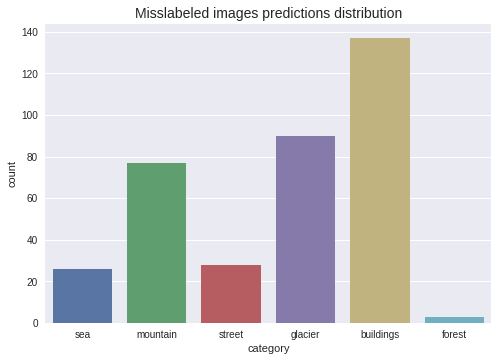

In [0]:
sns.countplot(x='category', data=misslabeled_test_df)
plt.title('Misslabeled images predictions distribution', fontsize=14)

*As we see from the graph above, category **buildings** has the biggest number of wrong predictions*





*Images from category **buildings** mostly predicted as  **street**:*

In [0]:
misslabeled_test_df.groupby(['category', 'predictions'])['image'].nunique()

category   predictions
buildings  forest           5
           mountain         1
           sea              3
           street         128
forest     glacier          1
           sea              2
glacier    buildings        4
           forest           5
           mountain        52
           sea             24
           street           5
mountain   buildings        4
           forest           4
           glacier         54
           sea              8
           street           7
sea        buildings        6
           forest           1
           glacier          3
           mountain        10
           street           6
street     buildings       21
           forest           5
           mountain         1
           sea              1
Name: image, dtype: int64

### Plotting random images, which were misslabeled

In [0]:
misslabeled_test_df.reset_index(inplace=True)

*Information above each image* - **label - correct label, pred - model prediction**

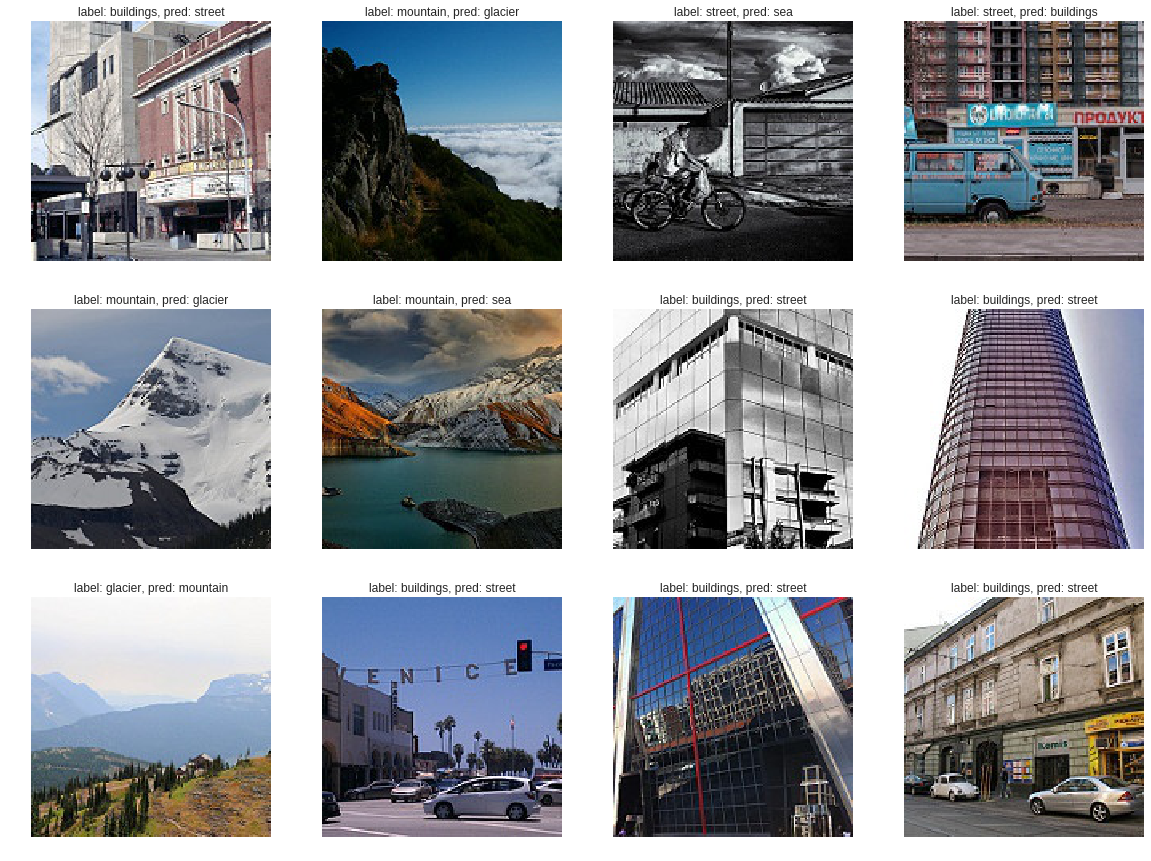

In [0]:
plot_df_images(misslabeled_test_df, 'path', 'category', 3, 4, 'predictions')

## Predicting labels for unlabeled images using Final model

In [0]:
def make_df_from_dir_no_labels(path):
    data1 = {
        'image': [],
        'path':[],
        'shape': [], 
    }
    for item in os.listdir(DATA_DIR/path):
        data1['image'].append(f"{item}")
        data1['path'].append(DATA_DIR/path/item)            
        data1['shape'].append(np.array(Image.open(DATA_DIR/path/item)).shape)
            
        
    return pd.DataFrame(data1)

In [0]:
predict_no_labels_df = make_df_from_dir_no_labels('seg_pred/seg_pred')

In [0]:
predict_no_labels_df.to_csv(str(TEMP_DIR/'predict_no_labels_df.csv'), index=False)

In [0]:
predict_no_labels_df = pd.read_csv(str(TEMP_DIR/'predict_no_labels_df.csv'))

In [0]:
predict_no_labels_df.shape

(7301, 3)

In [0]:
# Dummy label
predict_no_labels_df['category'] = 'sea'

In [0]:
pred_dataset, pred_dataset_length, pred_batch_size = prepare_ds(
    x=np.array([str(DATA_DIR/"seg_pred/seg_pred"/f"{getattr(row, image_path_col)}") for row in predict_no_labels_df.itertuples()]),
    y=label_pipeline.transform(predict_no_labels_df[target_col]),
    batch_size=2,
    parse_fn=image_parse,
    augment_fn=augment,
    mode="crop",
    shuffle=False,
    prefetch=0,
    num_parallel_calls=-1,
)

In [0]:
pred_predictions = model_1.predict(
    pred_dataset,
    steps=math.ceil(pred_dataset_length/test_batch_size),
)

In [0]:
pred_predictions.argmax(axis=1)

array([2, 4, 5, ..., 0, 4, 5])

In [0]:
pred_pred_orig_labels = label_pipeline.inverse_transform(pred_predictions.argmax(axis=1))

In [0]:
pred_pred_orig_labels

array(['sea', 'sea', 'street', ..., 'buildings', 'sea', 'street'],
      dtype=object)

In [0]:
predict_with_guessed_labels_df = predict_no_labels_df.copy()

In [0]:
predict_with_guessed_labels_df['prediction'] = pred_pred_orig_labels

In [0]:
predict_with_guessed_labels_df['category'] = '-'

In [0]:
predict_with_guessed_labels_df.head(3)

image  ... prediction
0  18695.jpg  ...        sea
1   2920.jpg  ...        sea
2  11130.jpg  ...     street

[3 rows x 5 columns]

### Showing predicted labels for unlabeled images

*Predictions written above every image -* **pred: prediction of Final model**

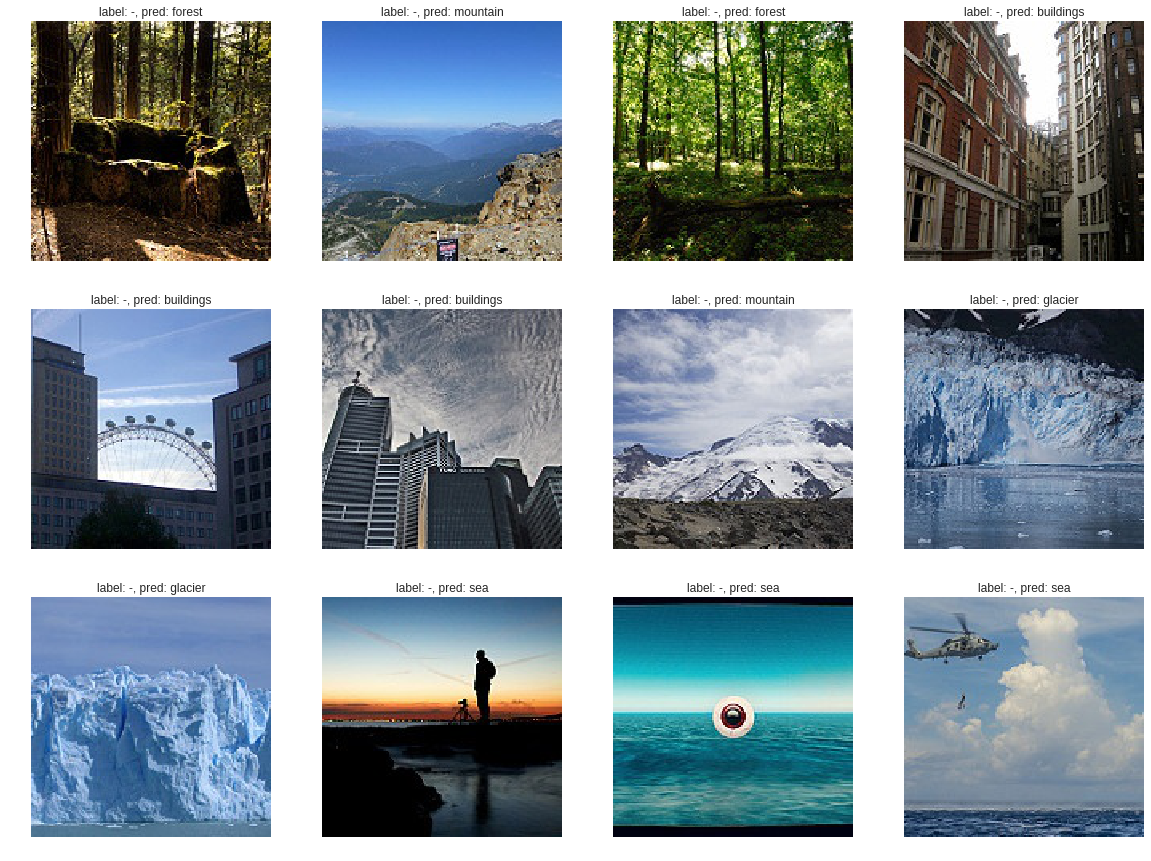

In [0]:
plot_df_images(predict_with_guessed_labels_df, 'path', 'category', 3, 4, 'prediction')

### Distribution of predicted labels for unlabeled images

In [0]:
predict_with_guessed_labels_df.groupby('prediction')['image'].nunique()

prediction
buildings     921
forest       1178
glacier      1233
mountain     1293
sea          1174
street       1502
Name: image, dtype: int64

Text(0.5, 1.0, 'Unlabeled images predictions distribution')

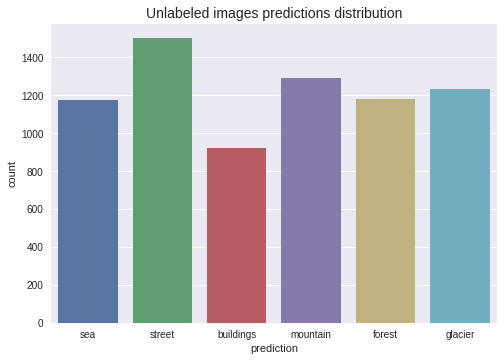

In [0]:
sns.countplot(predict_with_guessed_labels_df['prediction'], data=predict_with_guessed_labels_df)
plt.title('Unlabeled images predictions distribution', fontsize=14)

## Model with no weights from Xception

In [0]:
IMG_DIMS = (99, 99)

In [0]:
def make_model_n(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.Xception(weights=None, include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
model_no_w = make_model_n(
    n_classes=n_classes,
    input_shape=input_shape,
    dropout_rate=0.1,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
train_model(
    model=model_no_w,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=7,
    easing_epochs=2,
    model_name='model_no_w.h5',
)

W0818 14:25:31.609682 139801538598784 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/7
5263/5263 [==============================] - 768s 146ms/step - loss: 1.9741 - sparse_categorical_accuracy: 0.2795 - val_loss: 2.6720 - val_sparse_categorical_accuracy: 0.3046
Epoch 2/7
5263/5263 [==============================] - 729s 138ms/step - loss: 1.9048 - sparse_categorical_accuracy: 0.2483 - val_loss: 5.1496 - val_sparse_categorical_accuracy: 0.2844
Epoch 3/7
5263/5263 [==============================] - 744s 141ms/step - loss: 1.9257 - sparse_categorical_accuracy: 0.2299 - val_loss: 3.3961 - val_sparse_categorical_accuracy: 0.3001
Epoch 4/7
5263/5263 [==============================] - 764s 145ms/step - loss: 1.8703 - sparse_categorical_accuracy: 0.2496 - val_loss: 2.9929 - val_sparse_categorical_accuracy: 0.2739
Epoch 5/7
5263/5263 [==============================] - 749s 142ms/step - loss: 1.8692 - sparse_categorical_accuracy: 0.2478 - val_loss: 3.0224 - val_sparse_categorical_accuracy: 0.3710
Epoch 6/7
5263/5263 [==============================] - 742s 141ms/step - lo

In [0]:
model_no_w.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

1755/1755 [==============================] - 53s 30ms/step - loss: 4.9515 - sparse_categorical_accuracy: 0.3066


[4.951457747962443, 0.30664006]

In [0]:
model_no_w.evaluate(test_dataset, steps=math.ceil(test_dataset_length/test_batch_size))

1500/1500 [==============================] - 45s 30ms/step - loss: 4.8498 - sparse_categorical_accuracy: 0.3173


[4.849798691705413, 0.31733334]

In [0]:
val_predictions = model_no_w.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)

In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [0]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.39      0.07      0.11       565
         1.0       0.22      0.75      0.34       527
         2.0       0.37      0.15      0.21       635
         3.0       0.43      0.62      0.51       650
         4.0       0.14      0.01      0.02       563
         5.0       0.40      0.25      0.30       569

    accuracy                           0.31      3509
   macro avg       0.32      0.31      0.25      3509
weighted avg       0.33      0.31      0.25      3509



In [0]:
test_predictions = model_no_w.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [0]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.44      0.08      0.14       437
         1.0       0.22      0.72      0.34       474
         2.0       0.40      0.19      0.26       553
         3.0       0.42      0.62      0.50       525
         4.0       0.22      0.01      0.02       510
         5.0       0.42      0.28      0.34       501

    accuracy                           0.32      3000
   macro avg       0.36      0.32      0.26      3000
weighted avg       0.36      0.32      0.27      3000



## Model using MobileNetV2

In [0]:
IMG_DIMS = (128, 128)

In [0]:
input_shape = IMG_DIMS + (3,)

In [0]:
def make_model_mobilenetv2(
    n_classes,
    input_shape,
    dropout_rate=0.0,
    l1=1e-8,
    l2=1e-8,
):
    base_model = keras.applications.MobileNetV2(include_top=False, input_shape=input_shape)
    x = keras.layers.concatenate([
        keras.layers.GlobalAvgPool2D()(base_model.output),
        keras.layers.GlobalMaxPool2D()(base_model.output),
    ])
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        n_classes,
        kernel_regularizer=keras.regularizers.l1_l2(l1, l2),
        activation=keras.activations.softmax,
    )(x)
    return keras.Model(inputs=base_model.inputs, outputs=x)

In [0]:
model_mobilenetv2 = make_model_mobilenetv2(
    n_classes=n_classes,
    input_shape=input_shape,
    dropout_rate=0.2,
    l1=3e-6,
    l2=3e-5,
)

In [0]:
train_model(
    model=model_mobilenetv2,
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    epochs=7,
    easing_epochs=2,
    model_name='model_mobilenet.h5',
)

W0819 16:29:00.801922 139946164074368 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/7
5263/5263 [==============================] - 816s 155ms/step - loss: 1.3656 - sparse_categorical_accuracy: 0.5406 - val_loss: 1.6877 - val_sparse_categorical_accuracy: 0.5247
Epoch 2/7
5263/5263 [==============================] - 721s 137ms/step - loss: 1.3032 - sparse_categorical_accuracy: 0.5461 - val_loss: 1.1265 - val_sparse_categorical_accuracy: 0.6654
Epoch 3/7
5263/5263 [==============================] - 716s 136ms/step - loss: 1.2773 - sparse_categorical_accuracy: 0.5552 - val_loss: 0.9272 - val_sparse_categorical_accuracy: 0.6956
Epoch 4/7
5263/5263 [==============================] - 715s 136ms/step - loss: 1.2502 - sparse_categorical_accuracy: 0.5758 - val_loss: 0.9207 - val_sparse_categorical_accuracy: 0.7441
Epoch 5/7
5263/5263 [==============================] - 716s 136ms/step - loss: 1.1885 - sparse_categorical_accuracy: 0.6010 - val_loss: 0.6990 - val_sparse_categorical_accuracy: 0.7897
Epoch 6/7
5263/5263 [==============================] - 711s 135ms/step - lo

In [0]:
model_mobilenetv2 = keras.models.load_model(str(TEMP_DIR/'model_mobilenet.h5'))

In [75]:
model_mobilenetv2.evaluate(val_dataset, steps=math.ceil(val_dataset_length/val_batch_size))

1755/1755 [==============================] - 34s 19ms/step - loss: 0.6990 - sparse_categorical_accuracy: 0.7897


[0.698950322290373, 0.7896837]

In [76]:
model_mobilenetv2.evaluate(test_dataset, steps=math.ceil(test_dataset_length/test_batch_size))

1500/1500 [==============================] - 24s 16ms/step - loss: 0.6833 - sparse_categorical_accuracy: 0.7970


[0.6832566733978456, 0.797]

In [0]:
val_predictions = model_mobilenetv2.predict(
    val_dataset,
    steps=math.ceil(val_dataset_length/val_batch_size),
)

In [0]:
val_labels = np.concatenate([
    y.numpy() for _, y in val_dataset.take(math.ceil(val_dataset_length/val_batch_size))
])

In [79]:
print(classification_report(val_labels, val_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.77      0.77      0.77       565
         1.0       0.95      0.87      0.91       527
         2.0       0.80      0.65      0.72       635
         3.0       0.71      0.77      0.74       650
         4.0       0.72      0.86      0.78       563
         5.0       0.86      0.84      0.85       569

    accuracy                           0.79      3509
   macro avg       0.80      0.79      0.79      3509
weighted avg       0.80      0.79      0.79      3509



In [0]:
test_predictions = model_mobilenetv2.predict(
    test_dataset,
    steps=math.ceil(test_dataset_length/test_batch_size),
)

In [0]:
test_labels = np.concatenate([
    y.numpy() for _, y in test_dataset.take(math.ceil(test_dataset_length/test_batch_size))
])

In [82]:
print(classification_report(test_labels, test_predictions.argmax(axis=1)))

              precision    recall  f1-score   support

         0.0       0.75      0.81      0.78       437
         1.0       0.95      0.87      0.91       474
         2.0       0.79      0.66      0.72       553
         3.0       0.76      0.73      0.74       525
         4.0       0.70      0.88      0.78       510
         5.0       0.89      0.85      0.87       501

    accuracy                           0.80      3000
   macro avg       0.81      0.80      0.80      3000
weighted avg       0.80      0.80      0.80      3000



## Conclusion

The highest accuracy of **0.8953** *(on test_dataset)* was achieved with **Final model**:

    Xception
    IMG_DIMS = (150, 150)
    optimizer=keras.optimizers.Adam,
    lr=1e-4,
    dropout_rate=0.2,
    l1=3e-6,
    l2=3e-5,
    epochs=7,
    easing_epochs=3

Please see the section **Final model** for more information on result analysis.
    